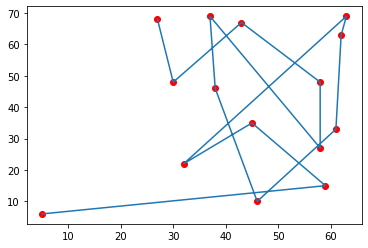

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 30 (0) rows, 210 (-15) columns and 420 (0) elements
Clp1000I sum of infeasibilities 9.7162e-07 - average 3.23873e-08, 192 fixed columns
Coin0506I Presolve 0 (-30) rows, 0 (-210) columns and 0 (-420) elements
Clp0000I Optimal - objective value 20066
Clp0000I Optimal - objective value 20066
Coin0511I After Postsolve, objective 20066, infeasibilities - dual 0 (0), primal 0 (0)
Clp0006I 0  Obj 20066 Dual inf 12209 (15)
Clp0014I Perturbing problem by 0.001% of 1.0000005 - largest nonzero change 2.0708098e-05 ( 0.0010354049%) - largest zero change 2.8835962e-05
Clp0000I Optimal - objective value 20066
Clp0000I Optimal - objective value 20066
Clp0000I Optimal - objective value 20066
Coin0511I After Postsolve, objective 20066, infeasibilities - dual 0 (0), primal 0 (0)
Clp0032I Optimal objective 20066 - 0 iterations time 0.002, Presolve 0.00, Idiot 0.00

Starting MIP optimization
Cbc0031I 5 

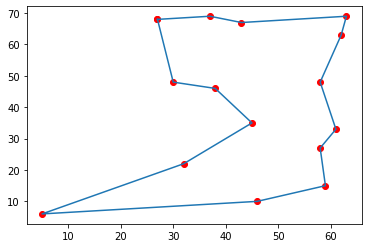

In [6]:
from typing import Tuple, Set, List
from math import floor, cos, acos
from itertools import product
from collections import defaultdict
from sys import stdout as out
from mip import Model, xsum, minimize, BINARY, ConstrsGenerator, CutPool
import matplotlib.pyplot as plt


def subtour(N: Set, outa: defaultdict, node) -> List:
    """checks if a given node belongs to a disconnected sub-route and
    returns involved nodes"""
    queue = [node]
    visited = set(queue)
    while queue:
        n = queue.pop()
        for nl in outa[n]:
            if nl not in visited:
                queue.append(nl)
                visited.add(nl)

    if len(visited) != len(N):
        return list(visited)
    else:
        return []


class SubTourLazyGenerator(ConstrsGenerator):
    """generated sub-tour elimination constraints"""

    def __init__(self, xv):
        self._x = xv

    def generate_constrs(self, model: Model, depth: int = 0, npass: int = 0):
        x_, N, cp = model.translate(self._x), range(len(self._x)), CutPool()
        outa = [[j for j in N if x_[i][j].x >= 0.99] for i in N]

        for node in N:
            S = set(subtour(N, outa, node))
            if S:
                AS = [(i, j) for (i, j) in product(S, S) if i != j]
                cut = xsum(x_[i][j] for (i, j) in AS) <= len(S) - 1
                cp.add(cut)
        for cut in cp.cuts:
            model += cut


# constants as stated in TSPlib doc
# https://www.iwr.uni-heidelberg.de/groups/comopt/software/TSPLIB95/tsp95.pdf
PI = 3.141592
RRR = 6378.388


def rad(val: float) -> float:
    """converts to radians"""
    mult = 1.0
    if val < 0.0:
        mult = -1.0
        val = abs(val)

    deg = float(floor(val))
    minute = val - deg
    return (PI * (deg + 5 * minute / 3) / 180) * mult


def dist(p1: Tuple[float, float], p2: Tuple[float, float]) -> float:
    """computes geographical distance"""
    q1 = cos(p1[1] - p2[1])
    q2 = cos(p1[0] - p2[0])
    q3 = cos(p1[0] + p2[0])
    return int(
        floor(RRR * acos(0.5 * ((1.0 + q1) * q2 - (1.0 - q1) * q3)) + 1.0)
    )

def draw(x,y):
    plt.plot(x, y)
    plt.scatter(x, y, c='r')
    plt.show()
    

filename = 'Input.txt'

xx=[]
yy=[]
coord =[]
quantity_points = 0

#чтение из файла
with open(filename, 'r') as f:
    for line in f:
        if quantity_points == 0:
          quantity_points = int(line) 
        else:
          coord.append([int(line.split()[0]),int(line.split()[1])])
          xx.append(int(line.split()[0]))
          yy.append(int(line.split()[1]))

route = list(range(0,quantity_points))

#input 
draw(xx,yy)
        
# latitude and longitude
coord = [(rad(x), rad(y)) for (x, y) in coord]

# distances in an upper triangular matrix

# number of nodes and list of vertices
n, V = len(coord), set(range(len(coord)))

# distances matrix
c = [[0 if i == j else dist(coord[i], coord[j]) for j in V] for i in V]

model = Model()

# binary variables indicating if arc (i,j) is used on the route or not
x = [[model.add_var(var_type=BINARY) for j in V] for i in V]

# objective function: minimize the distance
model.objective = minimize(xsum(c[i][j] * x[i][j] for i in V for j in V))

# constraint : leave each city only once
for i in V:
    model += xsum(x[i][j] for j in V - {i}) == 1

# constraint : enter each city only once
for i in V:
    model += xsum(x[j][i] for j in V - {i}) == 1

model.lazy_constrs_generator = SubTourLazyGenerator(x)

# optimizing
model.optimize(max_seconds=120)

string = '0 '
nx = []
ny = []
nroute = []

# checking if a solution was found
if model.num_solutions:
    out.write(
        "route with total distance %g found: %s" % (model.objective_value, 0)
    )
    nc = 0
    nroute.append(0)
    while True:
        nc = [i for i in V if x[nc][i].x >= 0.99][0]
        out.write(" -> %s" % nc) 
        string = string + str(nc) + ' '
        nroute.append(nc)
        if nc == 0:
            break
    out.write("\n")

#writing output
f = open('Output.txt', 'w')
f.write(str(model.objective_value)+'\n')
f.write(string)
f.close()

for i in range(0, len(nroute)):
  nx.append(xx[nroute[i]])
  ny.append(yy[nroute[i]])

draw(nx,ny)